#SNr model development notes

## 2015-06-17

Nakanishi, Kita & Kitai find two classes of SNr neuron, which they call Type I and Type II.

See "Intracellular study of rat substantia nigra pars reticulata neurons in an in vitro..." Brain Research, 437, 1987.

### Kita & Kitai Type I SNr neuron

The Type I neuron shows spontaneous firing, with a need to inject 0.06 nA to eliminate the firing.

The firing rate ranges from 0 to about 200 $\mathrm{s^{-1}}$ for hyperpolarizing currents from 0 to 0.6 nA.

### Kita & Kitai Type II SNr neuron

Similar to SNc neurons, no spontaneous firing, long duration action potentials (>2ms). Slow spiking for mod. injected currents, cessation of firing for large inj. currents.

I'll model the Type I neuron for the Spiking GPR model, so I'm trying to match the behaviour of Fig. 1 in Nakanishi, Kita & Kitai, 1987.

## SNr Model Parameters
You always have to run the next code block first, before any of the subsequent code blocks in this notebook.

In [1]:
# Here are the SNr model parameters
_a=0.12; _b=0.3; _c=-62; _d=0;
_vpeak=30;
#_A=0.04; _B=5; _C=140.25;
_A=0.0618; _B=6.6748; _C=169.248;
_T=0.1; _SI=8; # SI scales the effect of the input current independent of the parameter T
_vinit=-70; _uinit=-10;

##Quadratic manipulation

It's very easy to move the quadratic curve up and down by varying C, but it's harder to change its shape, as more than one of the quadratic's parameters have to be co-varied.

I find I need a tool to modify the quadratic curve in a sensible way and to then read off new, modified values of A, B and C. Let's build one:

In [2]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.html.widgets import interact

def quadmod (p1=200,p2=500,p3=800,dx1=0,dx2=0,dy2=0,dx3=0):

    # Model parameters pulled in from global scope
    A=_A; B=_B; C=_C; b=_b;

    # range for v
    v=np.linspace(-90,-20,1000)

    # Compute quadratic
    qcurve = A*v*v + B*v + C;

    # Plot it
    plt.figure(figsize=(18,10))
    plt.clf;
    plt.plot (v, qcurve)

    # Now go from three points to a quadratic.
    x=[v[p1]+dx1,v[p2]+dx2,v[p3]+dx3]
    y=[qcurve[p1],qcurve[p2]+dy2,qcurve[p3]]

    pf = np.polyfit (x,y,2)
    print 'ABC:',pf

    plt.plot (v[p1]+dx1,qcurve[p1], marker='o')
    plt.plot (v[p2]+dx2,qcurve[p2]+dy2, marker='o')
    plt.plot (v[p3]+dx3,qcurve[p3], marker='o')
    
    newqcurve = pf[0]*v*v + pf[1]*v + pf[2]
    plt.plot (v, newqcurve, color='g')
    
    # I'll draw the u nullcline here as well, as it's useful to
    # see that alongside the existing and new quadratics.
    u = v*b;
    plt.plot (v, u, color='r')

:0: FutureWarning: IPython widgets are experimental and may change in the future.


ABC: [  6.18000000e-02   6.67480000e+00   1.69248000e+02]


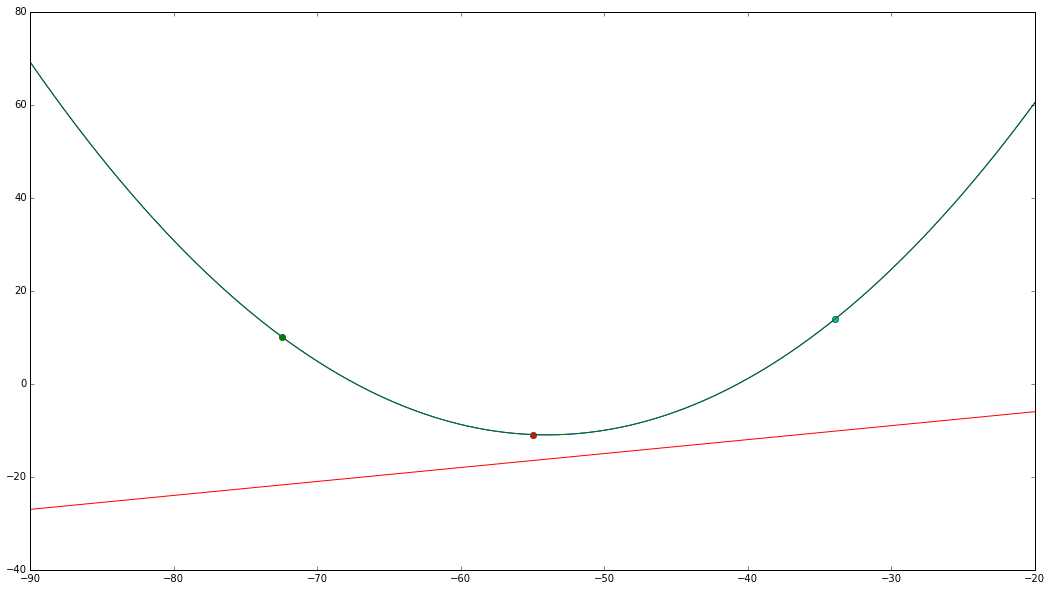

In [3]:
# This allows you to change the sliders for the three
# points from the existing A,B,C params and read off
# the new values for A, B and C
xrange=20
yrange=100
interact(quadmod,
         p1=(0,999,10),
         p2=(0,999,10),
         p3=(0,999,10),
         dx1=(-xrange,xrange,1),
         dx2=(-xrange,xrange,1),
         dy2=(-yrange,yrange,10),
         dx3=(-xrange,xrange,1))

## Explore Parameter Space
Now I can tweak A, B and C, lets look at the model...

In [3]:
# *Modify* the model then run it and finally analyse it.
def explore_abc_model (constI=0, a=_a, b=_b, c=_c, d=_d, 
                       vpeak=_vpeak, A=_A, B=_B, C=_C, T=_T, SI=_SI,
                       lowerV=-90, upperV=-20, qvloweru=-25, qvupperu=0, 
                       qpspacing=4, qpveclen=200, vinit=_vinit, uinit=_uinit):

    import sys
    sys.path.append("../analysis")

    # Where's the model and data?
    modeldir = '/home/seb/izhibg/GPR_Izhikevich/Izhi_SNr_I';
    expt = 0;
    population = 'Sebtest1'
    spineml2brahms ='/home/seb/src/SpineML_2_BRAHMS';
    spinemltmp = spineml2brahms+'/temp/log/';

    # Modify the model xml
    import update_abc_model_xml as abcupdate
    abcupdate.update_abc_model_xml (modeldir,expt,a,b,c,d,A,B,C,T,SI,vpeak,vinit,uinit)

    # Execute the model
    import os
    spinemlcmd = '/bin/bash -c "pushd '+spineml2brahms+' && '+\
                 'LD_LIBRARY_PATH=\"\" ./convert_script_s2b -m '+modeldir+' -e'+\
                 `expt`+' -c'+population+':I:'+`constI`+' ; popd"';
    os.system(spinemlcmd);

    # load the data from the model run
    import load_sc_data as lsd
    v, v_count, t, nn, dt = lsd.load_sc_data (spinemltmp+population+'_v_log.bin');
    u, u_count, tu, nnu, dtu = lsd.load_sc_data (spinemltmp+population+'_u_log.bin');

    import numpy as np

    # Compute nullclines
    I = np.zeros(v_count)+constI;
    Vn = np.linspace (lowerV, upperV, 1000);
    nc_v = A*np.power(Vn, 2)+ B*Vn + C + I[:len(Vn)]/SI;
    nc_u = Vn*b;

    # Compute vector field
    if qpspacing != 0:
        thescale = abs(lowerV-upperV)/qpspacing;
        Vgv = np.linspace(lowerV, upperV, thescale);
        ugv = np.linspace(qvloweru, qvupperu, thescale);
        Vg, ug = np.meshgrid(Vgv, ugv);
        vdot = T*A*Vg*Vg + T*B*Vg + T*C - T*ug + T*I[:len(Vg)]/SI;
        udot = T*a*(b*Vg - ug);
    
    # Plot the computed data
    %matplotlib inline
    import plot_izhi as pizhi
    pizhi.plot_izhi ('SNr candidate model', v, u, Vn, nc_v, nc_u, Vg, ug, vdot, udot,
                     lowerV, upperV, qvloweru, qvupperu, qpspacing, qpveclen)
    
    # Now plot the time series
    import matplotlib.pyplot as plt
    plt.figure(figsize=(18,10))
    plt.clf;
    plt.plot (t, v)
    plt.xlabel('t (ms)')
    plt.ylabel('v')
 
    import firing_rate as fr
    rate, isiRate = fr.firing_rate (v, t[len(t)-1], 0.1)
    print 'rate:', rate, ' isiRate:', isiRate


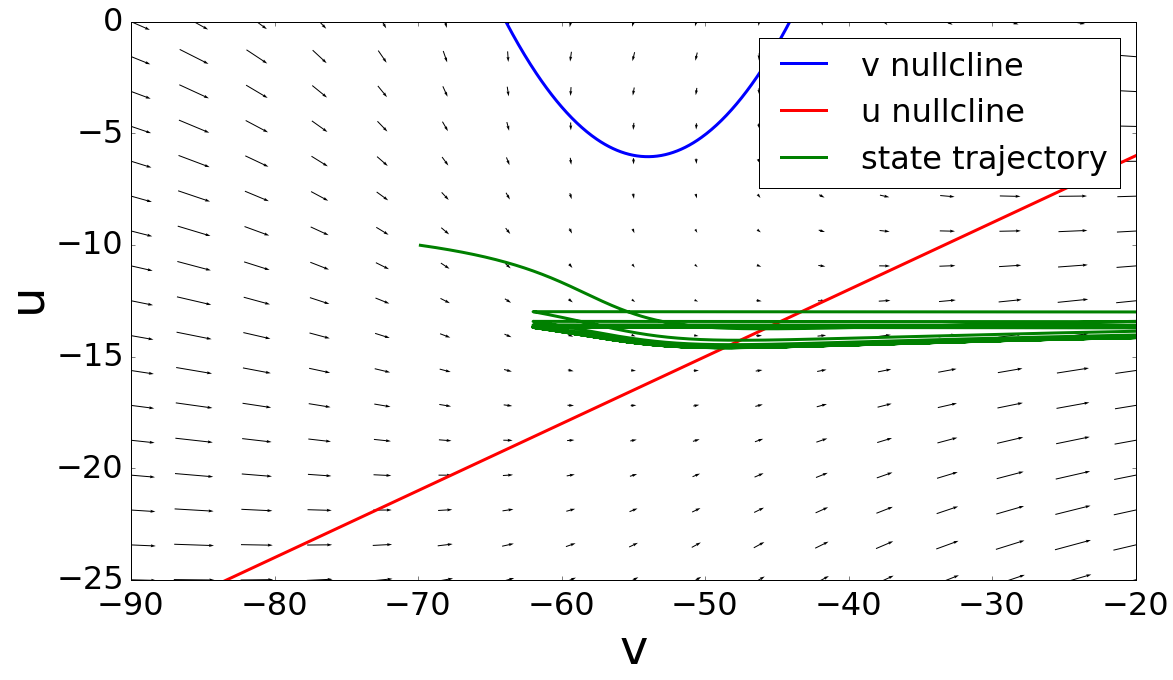

rate: 18.00180018  isiRate: 18.037879547


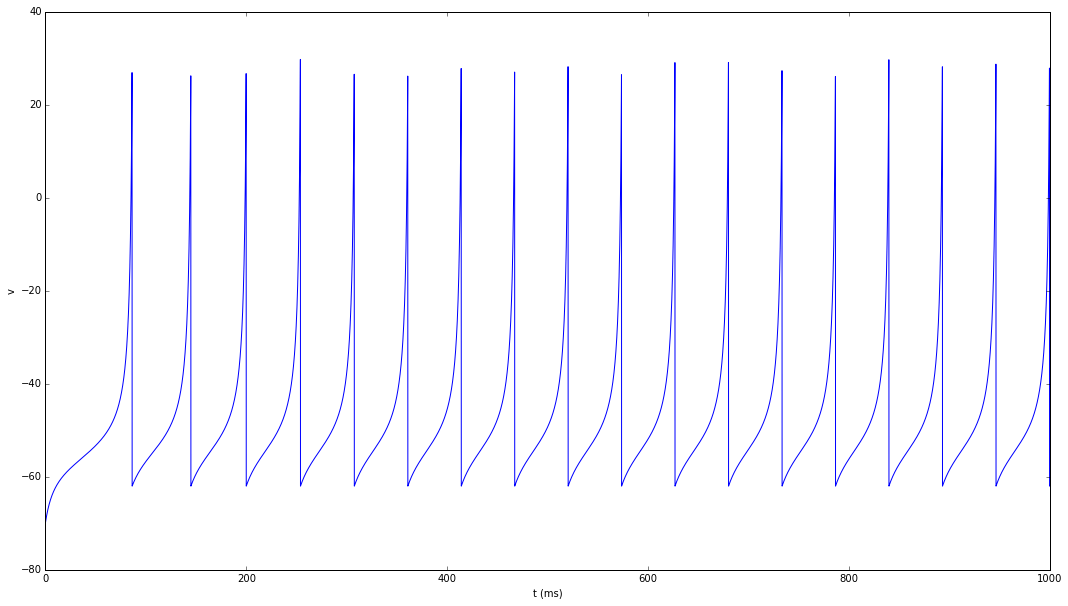

In [4]:
from IPython.html.widgets import interact

interact(explore_abc_model,
         vpeak=(20,40,1),
         lowerV=(-150,-40,1),
         upperV=(-40,60,1),
         qvloweru=(-60,0,1),
         qvupperu=(-6,40,1),
         qpspacing=(0,6,0.1),
         qpveclen=(10,300,10),
         constI=(-100,100,0.5),
         a=(0.0,2,0.01),
         b=(0.100,0.300,0.01),
         c=(-120,30,1),
         d=(0,5,0.01),
         T=(0.0,10.0,0.1),
         A=(0.03,0.1,0.0001),
         B=(3,10,0.01),
         C=(100,1000,1),
         vinit=(-120,30,.1),
         uinit=(-20,10,.1));

## f-I Curve

In [7]:
# Do a sweep through the currents with a given set of parameters.
def abc_snr_rate_sweep (constIlist):
    # Set your parameters here...
    expt = 0;
    population='Sebtest1'
    a=_a; b=_b; c=_c; d=_d
    vpeak=_vpeak;
    A=_A; B=_B; C=_C; T=_T; SI=_SI;
    #lowerV=-80; upperV=-20; qvloweru=-16; qvupperu=-10
    vinit=_vinit; uinit=_uinit
    # Where's the model and data?
    modeldir = '/home/seb/izhibg/GPR_Izhikevich/Izhi_SNr_I';
    spineml2brahms ='/home/seb/src/SpineML_2_BRAHMS';
    spinemltmp = spineml2brahms+'/temp/log/';

    # Modify the model xml
    import update_abc_model_xml as abcupdate
    abcupdate.update_abc_model_xml (modeldir,expt,a,b,c,d,A,B,C,T,SI,vpeak,vinit,uinit)

    # Execute the model
    import os
    import load_sc_data as lsd
    import firing_rate as fr

    # Put this in a loop, and do some analysis to extract the firing rate from the output.
    rates=[];
    isiRates=[];
    for constI in constIlist:
        spinemlcmd = '/bin/bash -c "pushd '+spineml2brahms+' && ' \
            +'LD_LIBRARY_PATH=\"\" ./convert_script_s2b -m '+modeldir+' -e' \
            +`expt`+' -c'+population+':I:'+`constI`+' ; popd"';
        os.system(spinemlcmd);

        # load the data from the model run
        v, v_count, t, nn, dt = lsd.load_sc_data (spinemltmp+population+'_v_log.bin');
        u, u_count, tu, nnu, dtu = lsd.load_sc_data (spinemltmp+population+'_u_log.bin');
    
        rate, isiRate = fr.firing_rate (v, t[len(t)-1], 0.1)
        print 'rate:', rate, ' isiRate:', isiRate
        rates.append(rate);
        isiRates.append(isiRate);

    return rates, isiRates


rate: 18.00180018  isiRate: 18.6974135245
rate: 18.00180018  isiRate: 18.7188019967
rate: 18.00180018  isiRate: 18.7813021703
rate: 19.00190019  isiRate: 19.0667335675
rate: 19.00190019  isiRate: 19.7054552997
rate: 22.00220022  isiRate: 22.0927897168
rate: 28.00280028  isiRate: 28.4958273967
rate: 48.00480048  isiRate: 48.323769254
rate: 67.0067006701  isiRate: 67.7451971689
rate: 82.0082008201  isiRate: 83.1474345974
rate: 112.01120112  isiRate: 113.498175922
rate: 130.0130013  isiRate: 131.659522352
rate: 147.01470147  isiRate: 149.420613946


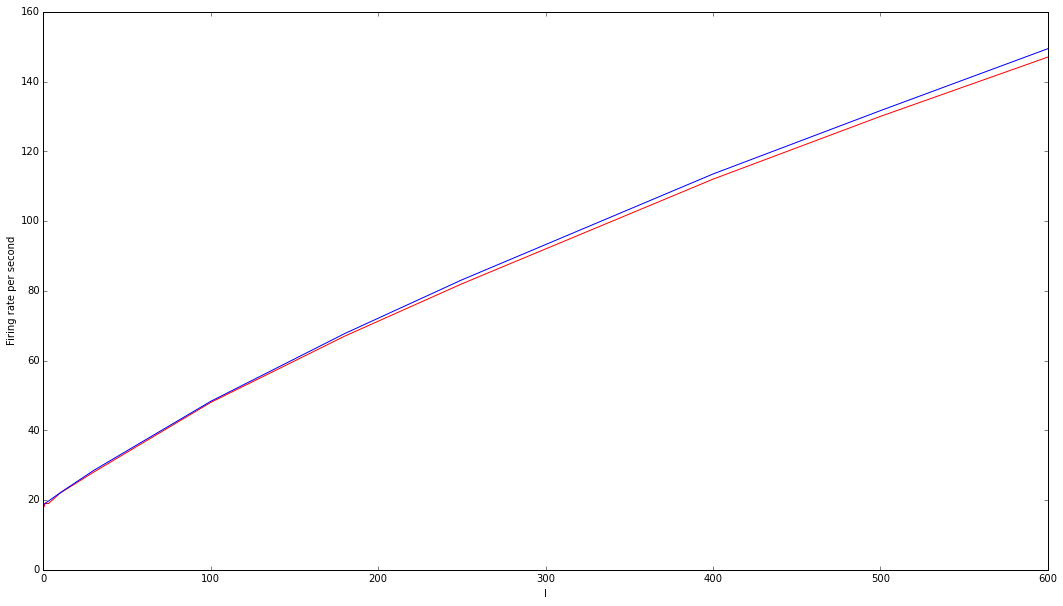

In [8]:
constIlist = [0, 0.1, 0.3, 1, 3, 10, 30, 100, 180, 250,400,500,600]
rates, isiRates = abc_snr_rate_sweep(constIlist)
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(18,10))
plt.clf;
plt.plot (constIlist, rates, color='r')
plt.plot (constIlist, isiRates, color='b')
plt.xlabel('I')
plt.ylabel('Firing rate per second')

## Review behaviour of the model
Here, you can look through the different experiments defined in the SpineCreator experiment interface, to check if the model shows the correct behaviour.

In [9]:
# *Read* the model then run it and finally analyse it.
def run_abc_model (expt=0, lowerV=-80, upperV=-20, qvloweru=-16, qvupperu=-10,
                   qpspacing=3, qpveclen=70):

    import sys
    sys.path.append("../analysis")

    # Where's the model and data?
    modeldir = '/home/seb/izhibg/GPR_Izhikevich/Izhi_SNr_I';
    population = 'Sebtest1';
    spineml2brahms ='/home/seb/src/SpineML_2_BRAHMS';
    spinemltmp = spineml2brahms+'/temp/log/';

    # Modify the model xml
    import read_abc_model_xml as abcread
    a,b,c,d,A,B,C,T,vpeak,vinit,uinit = abcread.read_abc_model_xml (modeldir,expt)
    
    # Execute the model
    import os
    spinemlcmd = '/bin/bash -c "pushd '+spineml2brahms+' && '+\
                 'LD_LIBRARY_PATH=\"\" ./convert_script_s2b -m '+modeldir+' -e'+\
                 `expt`+' ; popd"'; # omit: +' -c'+population+':I:'+`constI`
    os.system(spinemlcmd);

    # load the data from the model run
    import load_sc_data as lsd
    v, v_count, t, nn, dt = lsd.load_sc_data (spinemltmp+population+'_v_log.bin');
    u, u_count, tu, nnu, dtu = lsd.load_sc_data (spinemltmp+population+'_u_log.bin');

    import numpy as np

    # Temporary hack - better to get this from experiment xml,
    # but what's to say it isn't a time varying current?
    constI = 0
    
    # Compute nullclines
    Vn = np.linspace (lowerV, upperV, 1000);
    I = np.zeros(v_count)+constI;
    nc_v = A*np.power(Vn, 2)+ B*Vn + C + I[:len(Vn)];
    nc_u = Vn*b;

    # Compute vector field
    if qpspacing != 0:
        thescale = abs(lowerV-upperV)/qpspacing;
        Vgv = np.linspace(lowerV, upperV, thescale);
        ugv = np.linspace(qvloweru, qvupperu, thescale);
        Vg, ug = np.meshgrid(Vgv, ugv);
        vdot = T*A*Vg*Vg + T*B*Vg + T*C - T*ug + T*I[:len(Vg)];
        udot = T*a*(b*Vg - ug);
    
    # Plot it.
    %matplotlib inline
    import plot_izhi as pizhi
    pizhi.plot_izhi ('SNr candidate model', v, u, Vn, nc_v, nc_u, Vg, ug, vdot, udot,
                     lowerV, upperV, qvloweru, qvupperu, qpspacing, qpveclen)
    
    # Now plot the time series
    import matplotlib.pyplot as plt
    plt.figure(figsize=(18,10))
    plt.clf;
    plt.plot (t, v)
    plt.xlabel('t (ms)')
    plt.ylabel('v')
    plt.plot (t, u, color='r')
    plt.xlabel('t (ms)')
    plt.ylabel('v/u')

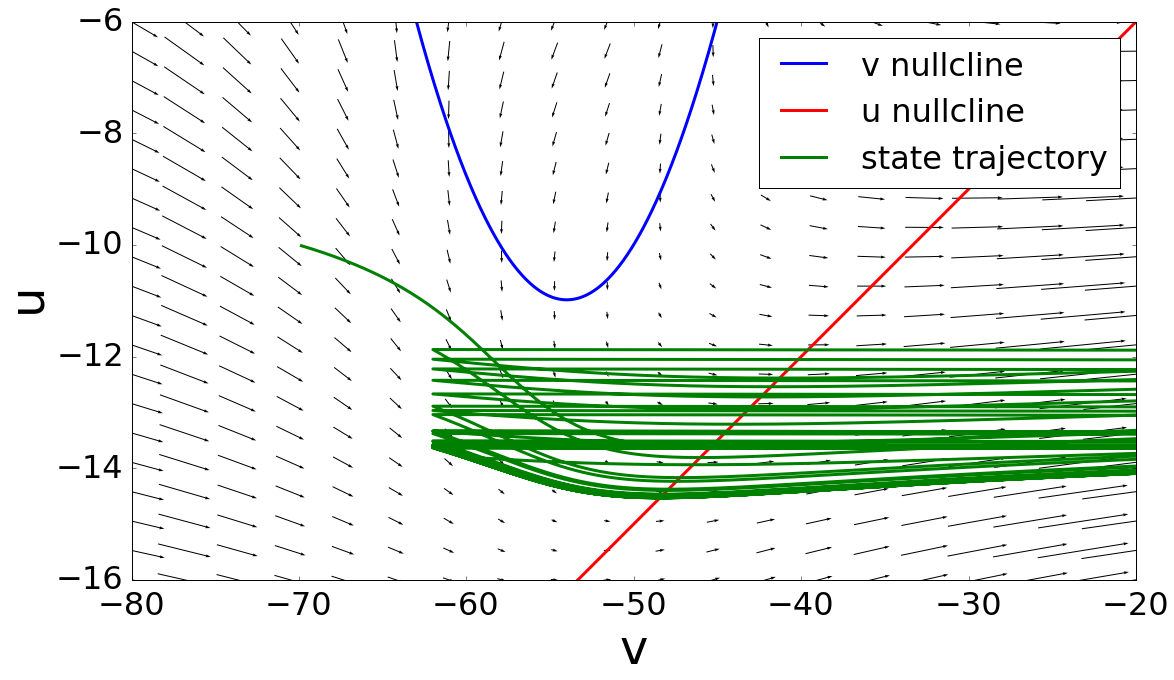

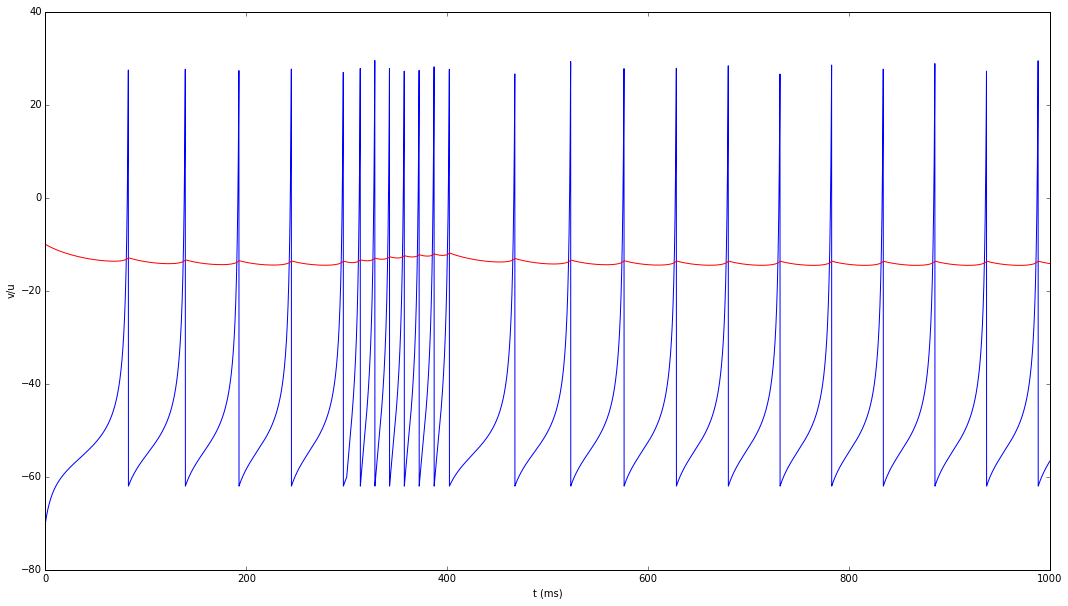

In [10]:
from IPython.html.widgets import interact

interact(run_abc_model,
         expt=(0,5,1),
         lowerV=(-120,-40,1),
         upperV=(-40,60,1),
         qvloweru=(-20,0,1),
         qvupperu=(-6,10,1),
         qpspacing=(0,10,0.5),
         qpveclen=(10,300,10))

##18th June
I find I want to be able to pass in a series of time-varying inputs for an experiment, so it would be good to be able to configure the expt run via SpineML_PreFlight. This will help me to try to reproduce Fig 1. of Nakanishi et al. I'll add an option -t, --time_varying_current=STRING with the string a set of comma separated values.

Ok, did that. Now lets try it out!

### Exploring Top Hat style input
The data in Fig 1. of Nakanishi et al. is all based on input currents which have a top hat shape, so lets build a function to analyse this sort of experiment, then after that I'll make scheme to sweep through and record all the results in a single graph, just like Fig. 1.

In [11]:
# *Modify* the model then run it and finally analyse it.
def explore_tophat (baseI=-50, hatI=100, hatPeriod=237, a=_a, b=_b, c=_c, d=_d, 
                    vpeak=_vpeak, A=_A, B=_B, C=_C, T=_T, SI=_SI,
                    lowerV=-90, upperV=-20, qvloweru=-25, qvupperu=0, 
                    qpspacing=4, qpveclen=200, vinit=_vinit, uinit=_uinit):

    import sys
    sys.path.append("../analysis")

    # Where's the model and data?
    modeldir = '/home/seb/izhibg/GPR_Izhikevich/Izhi_SNr_I';
    expt = 4; # Has timevarying input already
    population = 'Sebtest1'
    spineml2brahms ='/home/seb/src/SpineML_2_BRAHMS';
    spinemltmp = spineml2brahms+'/temp/log/';

    # Modify the model xml
    import update_abc_model_xml as abcupdate
    abcupdate.update_abc_model_xml (modeldir,expt,a,b,c,d,A,B,C,T,SI,vpeak,vinit,uinit)

    # A top hat input, going to max of constI. 237 ms of "up" to match Fig. 1 in Nakanishi et al.
    tv = [0,baseI,300,hatI,300+hatPeriod,baseI]
    tvlist = ''
    first = True
    for tvi in tv:
        if first==True:
            first = False
        else:
            tvlist += ','
        tvlist += `tvi`    
    
    # Execute the model
    import os
    spinemlcmd = '/bin/bash -c "pushd '+spineml2brahms+' && '+\
                 'LD_LIBRARY_PATH=\"\" ./convert_script_s2b -m '+modeldir+' -e'+\
                 `expt`+' -t'+population+':I:'+tvlist+' ; popd"';
    os.system(spinemlcmd);

    # load the data from the model run
    import load_sc_data as lsd
    v, v_count, t, nn, dt = lsd.load_sc_data (spinemltmp+population+'_v_log.bin');
    u, u_count, tu, nn, dt = lsd.load_sc_data (spinemltmp+population+'_u_log.bin');

    # Make data for the input current
    tvdata = [];
    i = 0
    while i<len(t):
        if t[i]>=300 and t[i] < 300+hatPeriod:
            tvdata.append(hatI)
        else:
            tvdata.append(baseI)
        i=i+1
    
    import numpy as np

    # Compute nullclines
    I_base = np.zeros(v_count)+baseI;
    I_hat = np.zeros(v_count)+hatI;
    Vn = np.linspace (lowerV, upperV, 1000);
    nc_v_base = A*np.power(Vn, 2)+ B*Vn + C + I_base[:len(Vn)]/SI;
    nc_v_hat =  A*np.power(Vn, 2)+ B*Vn + C + I_hat[:len(Vn)]/SI;
    nc_u = Vn*b;

    # Compute vector field
    if qpspacing != 0:
        thescale = abs(lowerV-upperV)/qpspacing;
        Vgv = np.linspace(lowerV, upperV, thescale);
        ugv = np.linspace(qvloweru, qvupperu, thescale);
        Vg, ug = np.meshgrid(Vgv, ugv);
        vdot = T*A*Vg*Vg + T*B*Vg + T*C - T*ug + T*I_base[:len(Vg)]/SI;
        udot = T*a*(b*Vg - ug);
    
    nc_v = [nc_v_base, nc_v_hat]
    
    # Plot the computed data
    %matplotlib inline
    import plot_izhi as pizhi
    pizhi.plot_izhi ('SNr candidate model', v, u, Vn, nc_v, nc_u, Vg, ug, vdot, udot,
                     lowerV, upperV, qvloweru, qvupperu, qpspacing, qpveclen)
    
    # Now plot the time series
    import matplotlib.pyplot as plt
    fig, ax1 = plt.subplots(figsize=(18,14))
    ax1.plot (t, v, color='b')
    ax1.set_xlabel('t (ms)')
    ax1.set_ylabel('v', color='b')
    for tl in ax1.get_yticklabels():
        tl.set_color('b')
    # Now make a twin of ax1:
    ax2 = ax1.twinx()
    ax2.plot(t, tvdata, 'r')
    ax2.set_ylim(-1000,120)
    ax2.set_ylabel('Injection Current', color='r')
    for tl in ax2.get_yticklabels():
        tl.set_color('r')
    plt.show()

    import firing_rate as fr
    rate, isiRate = fr.firing_rate (v, t[len(t)-1], 0.1)
    print 'rate:', rate, ' isiRate:', isiRate
 

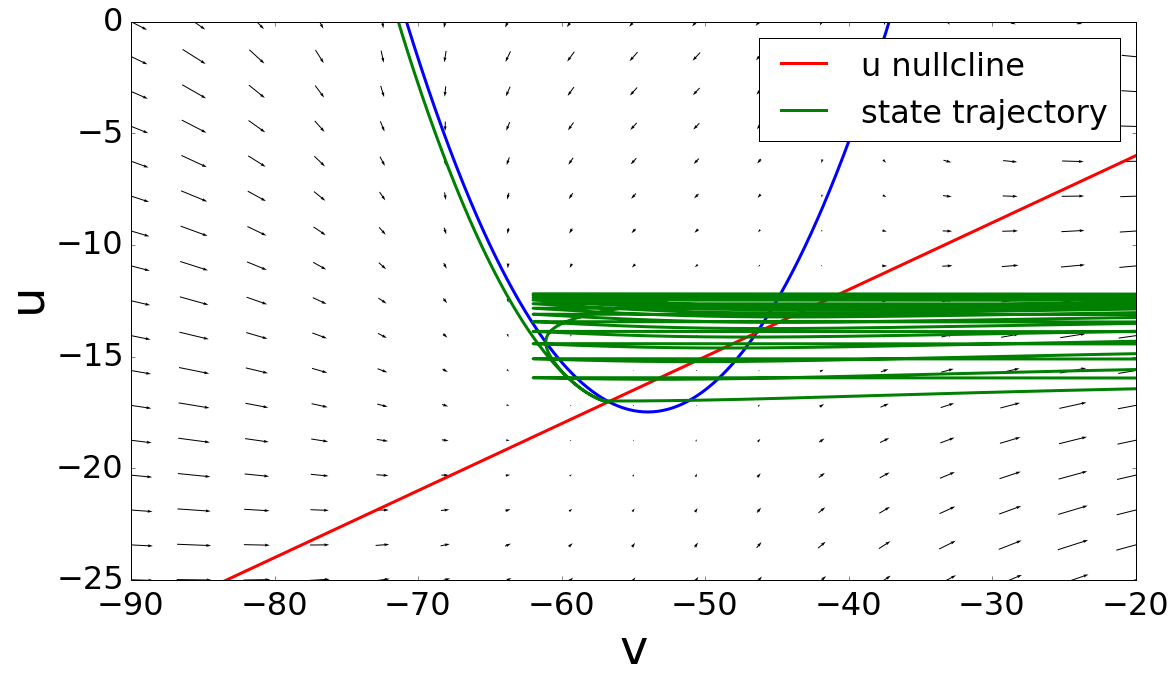

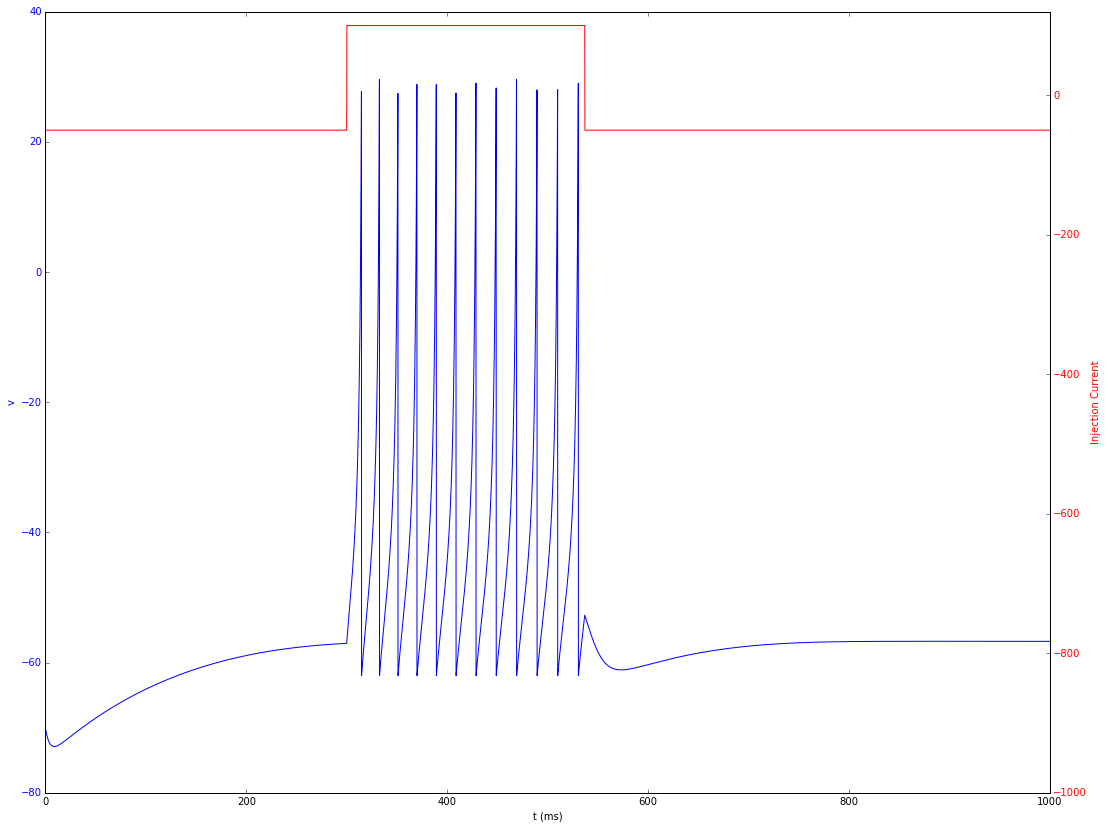

rate: 12.00120012  isiRate: 22.6671703816


In [12]:
from IPython.html.widgets import interact

interact(explore_tophat,
         vpeak=(20,40,1),
         lowerV=(-150,-40,1),
         upperV=(-40,60,1),
         qvloweru=(-60,0,1),
         qvupperu=(-6,40,1),
         qpspacing=(0,6,0.1),
         qpveclen=(10,300,10),
         baseI=(-1000,200,10),
         hatI=(-1000,200,10),
         hatPeriod=(0,1000,10),
         a=(0.0,2,0.01),
         b=(0.100,0.300,0.01),
         c=(-120,30,1),
         d=(-3,5,0.01),
         T=(0.0,10.0,0.1),
         A=(0.03,0.1,0.0001),
         B=(3,10,0.01),
         C=(100,1000,1),
         vinit=(-120,30,.1),
         uinit=(-20,10,.1));

##2015-06-19
I'm happy with the model as it stands; it has behaviour close enough to Nakanishi et al. I'll start building the network model next.

In [13]:
# 2015-06-19 model params.
_a=0.12; _b=0.3; _c=-62; _d=0;
_vpeak=30;
_A=0.0618; _B=6.6748; _C=169.248;
_T=0.1; _SI=8;
_vinit=-70; _uinit=-10;

I was working with components called IzhiPaperTscaled. I've changed that name to IzhiABCTExplicit and there's a sister component called IzhiABCTFast, which has parameters AT, BT, CT, aT and T/SI to reduce the number of calculations.

In [14]:
# Compute parameters for IzhiABCTFast component:
AT=_A*_T
BT=_B*_T
CT=_C*_T
aT=_a*_T
ToverSI=float(_T)/_SI
print 'AT=',AT,'BT=',BT,'CT=',CT,'aT=',aT,'ToverSI=',ToverSI

AT= 0.00618 BT= 0.66748 CT= 16.9248 aT= 0.012 ToverSI= 0.0125
